In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -qU 'google-genai==1.7.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 3.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 3.1 MB/s eta 0:00:00


In [3]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

'1.7.0'

In [4]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

In [5]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

In [6]:
# Ask for information without search grounding.
response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="When and where is Billie Eilish's next concert?")

Markdown(response.text)

Unfortunately, Billie Eilish doesn't currently have any concerts scheduled.

*   **Official Website:** You can always check Billie Eilish's official website ([https://www.billieeilish.com/](https://www.billieeilish.com/)) for the most up-to-date information on tour dates and announcements.
*   **Social Media:** Follow her on social media (Instagram, Twitter, etc.) for announcements.


In [7]:
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

def query_with_grounding():
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents="When and where is Billie Eilish's next concert?",
        config=config_with_search,
    )
    return response.candidates[0]


rc = query_with_grounding()
Markdown(rc.content.parts[0].text)

Billie Eilish is currently on her "Hit Me Hard and Soft: The Tour". Here's a breakdown of some of her upcoming concerts:

*   **April 23 & 24, 2025:** Avicii Arena (formerly Ericsson Globe Arena), Stockholm, Sweden
*   **April 26, 2025:** Unity Arena (Former Telenor Arena), Fornebu, Norway
*   **April 28, 2025:** Royal Arena, Copenhagen, Denmark
*   **July 7, 2025:** OVO Hydro, Glasgow, United Kingdom
*   **July 26 & 27, 2025:** 3Arena, Dublin, Ireland

The tour continues through late July 2025, concluding in Dublin.


In [8]:
while not rc.grounding_metadata.grounding_supports or not rc.grounding_metadata.grounding_chunks:
    # If incomplete grounding data was returned, retry.
    rc = query_with_grounding()

chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

frontiertouring.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALq9BSHaIccOftmcL4vVBQtMTE2HnPGtn2EUKZjGdUBDXYv8AFscsqY_U_TBdVs1OeUulgRahmS3wCD1CHcQE9l02J9sRJIxkzmFKJhFS96081bX1rArxv4Ia-mp4c7yaqm44I6jTcG
ticketmaster.co.uk: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALRr3H7GbYKh7GdxUyzR4OcbkNc_dzWH-4nyvdpwlDVWcBvWDRAqfuNC4kc7ObSUols2SKgjtFBjvQDI1XweVtb44mPlCJycmxMO0grYLdW2DgdnwEzi2gSM65sEzMmolNk_X4jU8_6NGxKMD2okns5WQUZCfZN5VkUYNjpvsU=
wikipedia.org: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIJvXlJawL2IjZZPS7JwpeqlYmkcyStR2vbiPH0cBqsFAE69Le3PfTQ5io31MSYQtmdyTfW60i_4fEMpuW6LdcJIGwBz_o-Ib15jYrXsdsEb6hVNj5phSBinWloM9qiwaDsKp3Ip4vqRWYtWMq61LXEXOA3MsP38Q==


In [9]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

In [10]:
from pprint import pprint

supports = rc.grounding_metadata.grounding_supports
for support in supports:
    pprint(support.to_json_dict())

{'confidence_scores': [0.9173908, 0.6334672, 0.9073367],
 'grounding_chunk_indices': [0, 1, 2],
 'segment': {'end_index': 67,
             'text': 'Billie Eilish is currently on her "Hit Me Hard and Soft: '
                     'The Tour".'}}
{'confidence_scores': [0.6230004],
 'grounding_chunk_indices': [1],
 'segment': {'end_index': 214,
             'start_index': 122,
             'text': '*   **April 23 & 24, 2025:** Avicii Arena (formerly '
                     'Ericsson Globe Arena), Stockholm, Sweden'}}
{'confidence_scores': [0.6306657],
 'grounding_chunk_indices': [1],
 'segment': {'end_index': 290,
             'start_index': 215,
             'text': '*   **April 26, 2025:** Unity Arena (Former Telenor '
                     'Arena), Fornebu, Norway'}}
{'confidence_scores': [0.621308],
 'grounding_chunk_indices': [1],
 'segment': {'end_index': 347,
             'start_index': 291,
             'text': '*   **April 28, 2025:** Royal Arena, Copenhagen, '
                     '

In [11]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        rc.content.parts[0].text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

Supported text:

 * Billie Eilish is currently on her "Hit Me Hard and Soft: The Tour".<sup>[1]</sup><sup>[2]</sup><sup>[3]</sup>

 * *   **April 23 & 24, 2025:** Avicii Arena (formerly Ericsson Globe Arena), Stockholm, Sweden<sup>[2]</sup>

 * *   **April 26, 2025:** Unity Arena (Former Telenor Arena), Fornebu, Norway<sup>[2]</sup>

 * *   **April 28, 2025:** Royal Arena, Copenhagen, Denmark<sup>[2]</sup>

 * *   **July 7, 2025:** OVO Hydro, Glasgow, United Kingdom<sup>[2]</sup>

 * *   **July 26 & 27, 2025:** 3Arena, Dublin, Ireland<sup>[2]</sup>

 * The tour continues through late July 2025, concluding in Dublin.<sup>[2]</sup><sup>[3]</sup>

Citations:

1. [frontiertouring.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALq9BSHaIccOftmcL4vVBQtMTE2HnPGtn2EUKZjGdUBDXYv8AFscsqY_U_TBdVs1OeUulgRahmS3wCD1CHcQE9l02J9sRJIxkzmFKJhFS96081bX1rArxv4Ia-mp4c7yaqm44I6jTcG)
2. [ticketmaster.co.uk](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALRr3H7GbYKh7GdxUyzR4OcbkNc_dzWH-4nyvdpwlDVWcBvWDRAqfuNC4kc7ObSUols2SKgjtFBjvQDI1XweVtb44mPlCJycmxMO0grYLdW2DgdnwEzi2gSM65sEzMmolNk_X4jU8_6NGxKMD2okns5WQUZCfZN5VkUYNjpvsU=)
3. [wikipedia.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIJvXlJawL2IjZZPS7JwpeqlYmkcyStR2vbiPH0cBqsFAE69Le3PfTQ5io31MSYQtmdyTfW60i_4fEMpuW6LdcJIGwBz_o-Ib15jYrXsdsEb6hVNj5phSBinWloM9qiwaDsKp3Ip4vqRWYtWMq61LXEXOA3MsP38Q==)


In [12]:
from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

In [13]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0,
)

chat = client.chats.create(model='gemini-2.0-flash')

response = chat.send_message(
    message="What were the medal tallies, by top-10 countries, for the 2024 olympics?",
    config=config_with_search,
)

show_response(response)

Here is the top 10 medal tally for the 2024 Paris Olympics:

1.  **United States:** 40 Gold, 44 Silver, 42 Bronze (126 Total)
2.  **China:** 40 Gold, 27 Silver, 24 Bronze (91 Total)
3.  **Japan:** 20 Gold, 12 Silver, 13 Bronze (45 Total)
4.  **Australia:** 18 Gold, 19 Silver, 16 Bronze (53 Total)
5.  **France:** 16 Gold, 26 Silver, 22 Bronze (64 Total)
6.  **Netherlands:** 15 Gold, 7 Silver, 12 Bronze (34 Total)
7.  **Great Britain:** 14 Gold, 22 Silver, 29 Bronze (65 Total)
8.  **Republic of Korea:** 13 Gold, 9 Silver, 10 Bronze (32 Total)
9.  **Italy:** 12 Gold, 13 Silver, 15 Bronze (40 Total)
10. **Germany:** 12 Gold, 13 Silver, 8 Bronze (33 Total)



----

Okay, I can help you visualize this data using a Seaborn chart. I'll use a python code block to generate the plot.



----

{'executable_code': {'code': "import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Data for the medal tally\ndata = {\n    'Country': ['United States', 'China', 'Japan', 'Australia', 'France', 'Netherlands', 'Great Britain', 'Republic of Korea', 'Italy', 'Germany'],\n    'Gold': [40, 40, 20, 18, 16, 15, 14, 13, 12, 12],\n    'Silver': [44, 27, 12, 19, 26, 7, 22, 9, 13, 13],\n    'Bronze': [42, 24, 13, 16, 22, 12, 29, 10, 15, 8]\n}\n\ndf = pd.DataFrame(data)\n\n# Melt the dataframe to combine medal types into a single column\ndf_melted = pd.melt(df, id_vars=['Country'], value_vars=['Gold', 'Silver', 'Bronze'], var_name='Medal', value_name='Count')\n\n# Create the bar plot\nplt.figure(figsize=(12, 8))\nsns.barplot(x='Country', y='Count', hue='Medal', data=df_melted, palette=['#FFD700', '#C0C0C0', '#CD7F32']) # Gold, Silver, Bronze colors\nplt.title('2024 Olympics Medal Tally (Top 10 Countries)')\nplt.xlabel('Country')\nplt.ylabel('Number of Medals')\nplt.xtick

----

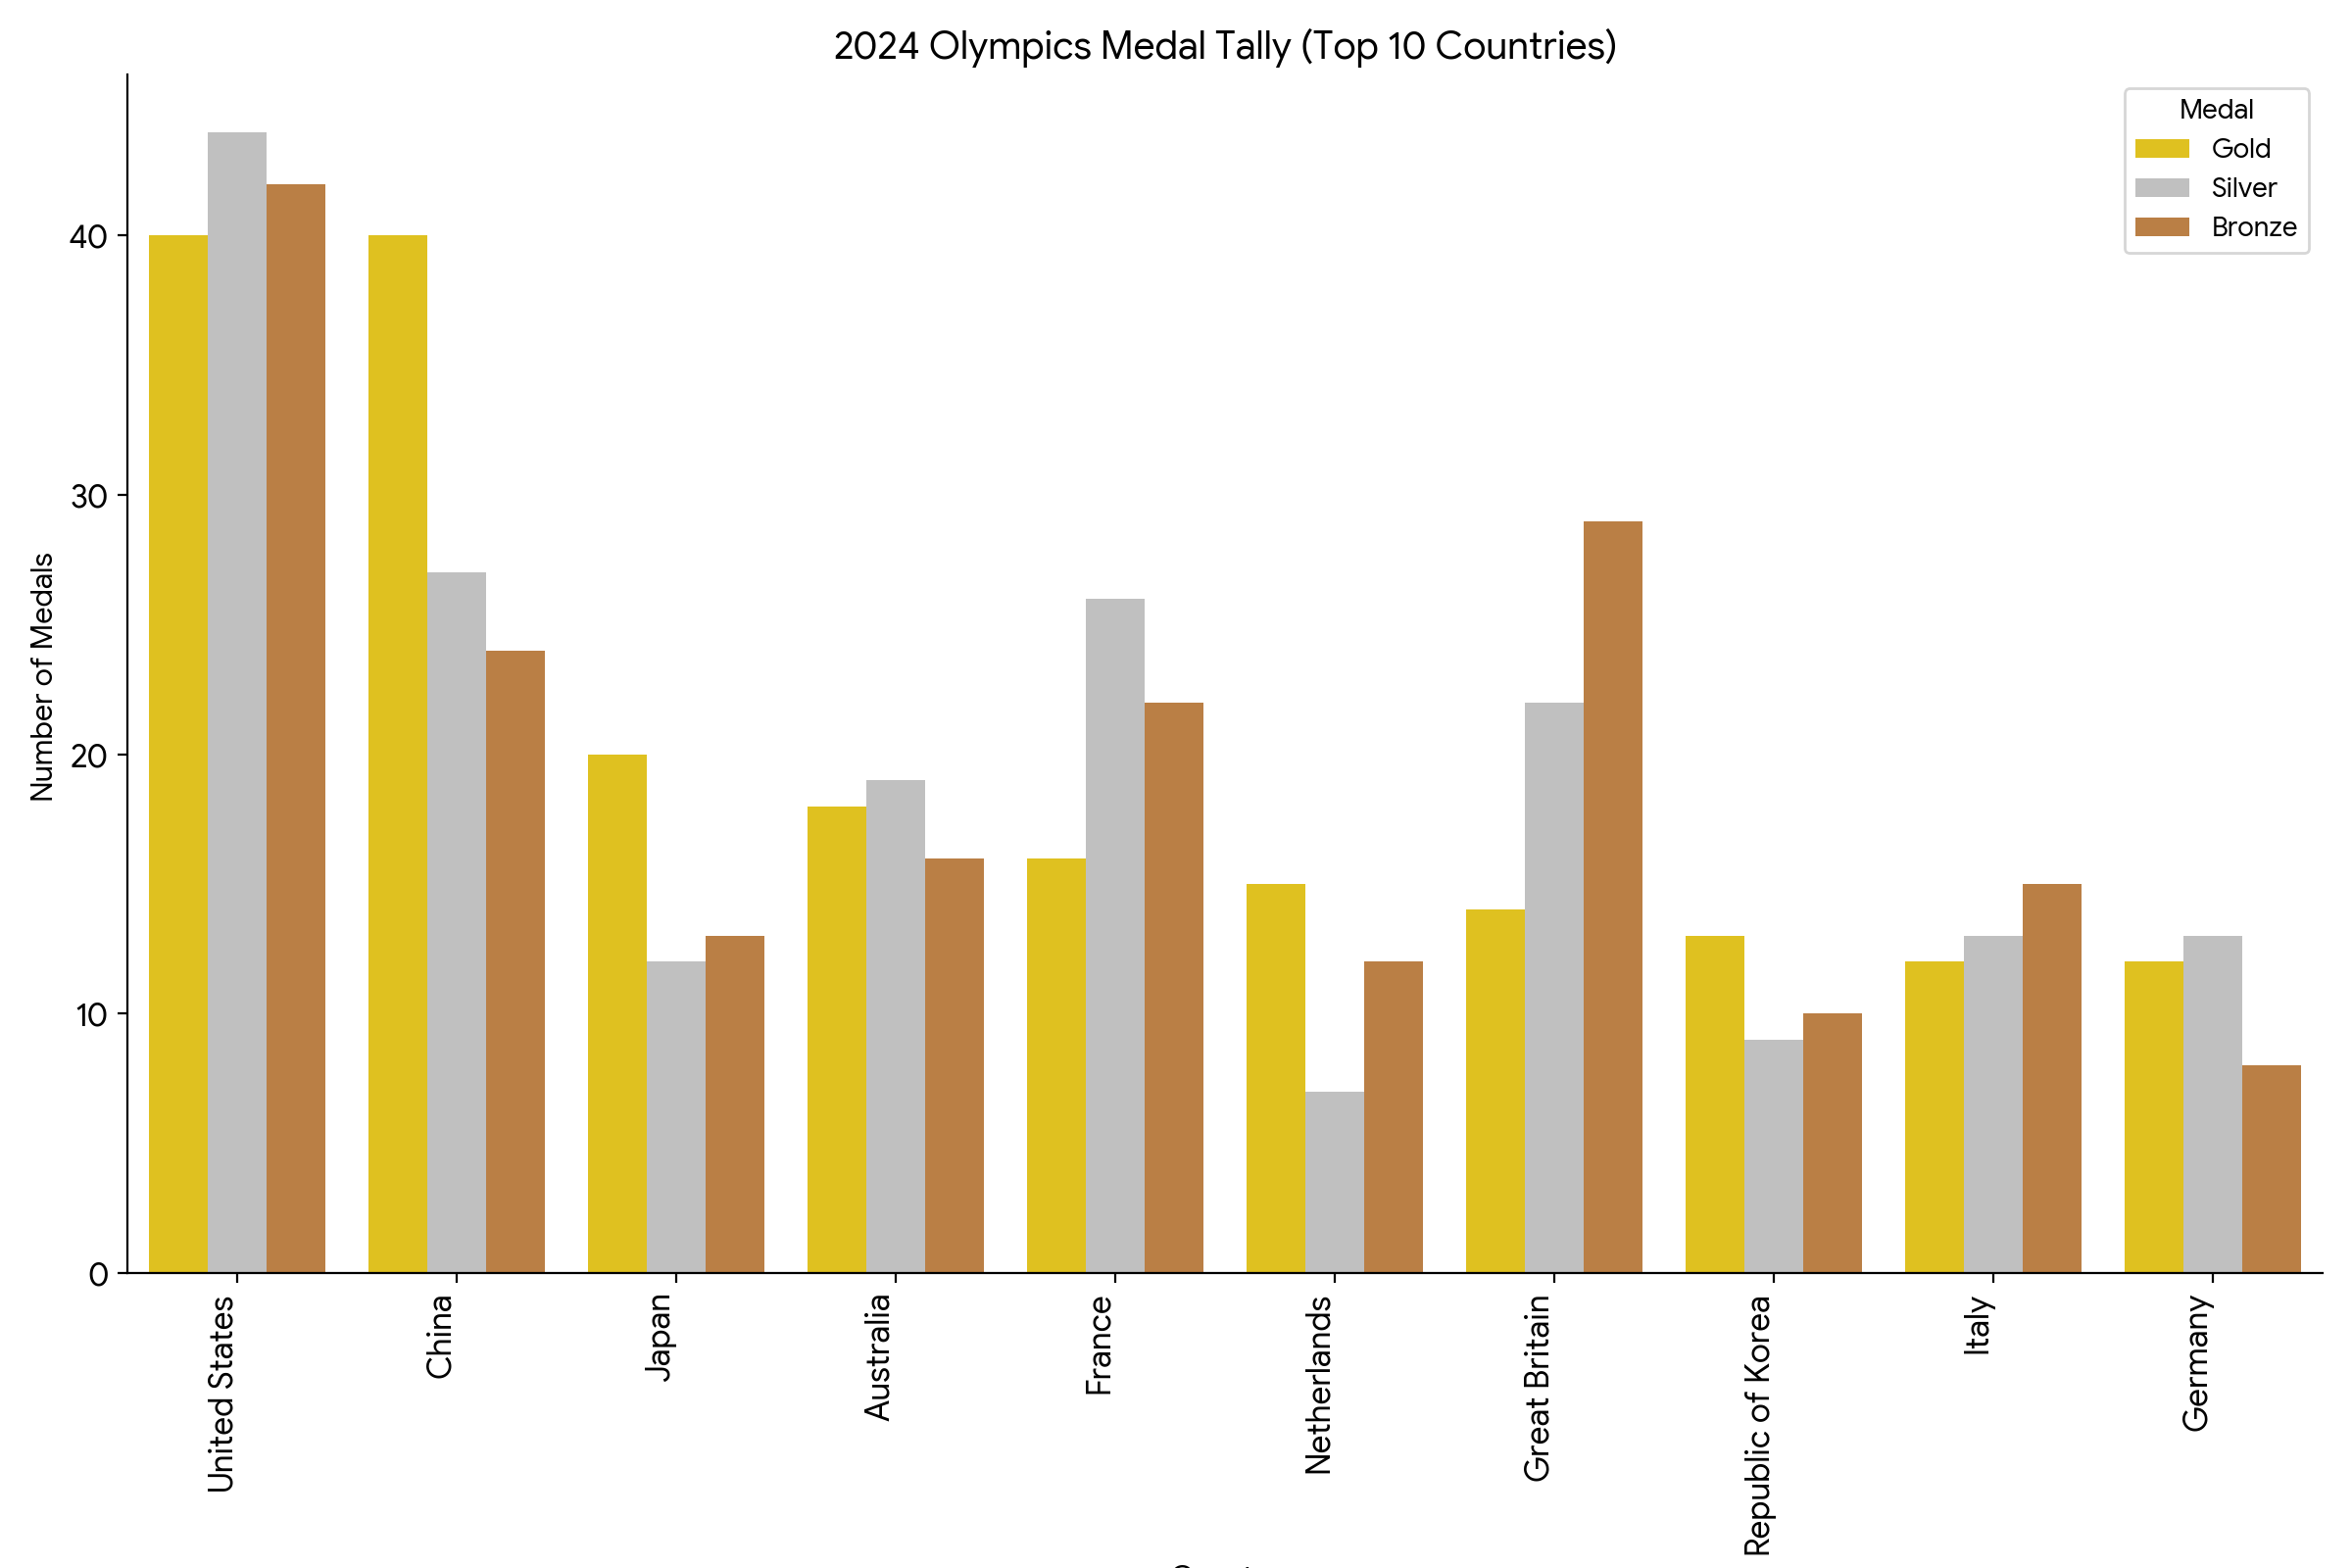

----

The code produced a bar plot showing the medal distribution (Gold, Silver, and Bronze) for the top 10 countries in the 2024 Olympics. The x-axis represents the countries, and the y-axis represents the number of medals. Each country has three bars representing the count of each medal type. The plot is titled "2024 Olympics Medal Tally (Top 10 Countries)". The x-axis labels (country names) are rotated for better readability.


----

In [14]:
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)

response = chat.send_message(
    message="Now plot this as a seaborn chart. Break out the medals too.",
    config=config_with_code,
)

show_response(response)